
# Energy A.I. Hackathon 2022 Workflow - Carpe Datum

#### Authors: Santosh Balachandra [ECE, Cockrell], Roberto Dailey [ORIE, Cockrell], Irvin Shen [ME, Cockrell], Rachel Welch [PGE, Cockrell]
#### The University of Texas at Austin, Austin, Texas USA 
___

### Executive Summary 

Only 4 short sentences.

1. Given data of 50 oil wells pumping from a channel, predict the optimal location for 3 new wells and forecast their 2-year production.

2. Employed machine learning and numerical methods to regress production across the field.
3. We furthered our understanding of geospatial data and working with sparse datasets.
4. Moving to production with the recommended well locations shown below.

___

### Workflow Goal

The goal of our workflow was to first fully understand our dataset using EDA and visualizations, before using inference, gradient boosted trees, and linear regression to predict production across the field.
___

### Workflow Steps 

Enumerated steps, very short and concise overview of your methods and workflow

1. **Data Cleaning** - Import data, check for outliers, combine datasets
2. **EDA** - Visualize data and analyze distributions
2. **Feature Imputation, Encoding, and Generation** - Use KNN and GridCV to impute values, along with tuning hyperparameters, also use empirical formulas to generate features
3. **Inference** - Infer features of potential wells based on X, Y, and AI
5. **Modelling** - Regress using a combination of gradient-boosted trees and least squares

$\ldots$


### Import Packages

The code block below loads the required libraries. 

In [1]:
# Filesystem manipulation
from pathlib import Path
import os

# Type hints and documentation
from typing import Tuple

# Data and array manipulation
import numpy as np
import pandas as pd

# Plotting and Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Numerical Methods, namely interpolation
import scipy.interpolate as interpolate

# Regression Algorithms
    # Train test split
from sklearn.model_selection import train_test_split
    # Linear Model 
from sklearn.linear_model import LinearRegression
    # Nearest Neighbors Models
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
    # Tree-based Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
    # Helper regression algorithms
from sklearn.ensemble import BaggingRegressor

# Imputation
from sklearn.neighbors import KNeighborsClassifier


# Data Scaling and Normalization
from sklearn.decomposition import PCA

from sklearn.preprocessing import (PolynomialFeatures, MaxAbsScaler, 
                                   MinMaxScaler, StandardScaler, RobustScaler)

# Metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error

# Data Segmentation and Model Validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline

# 


### Load Data


#### Well Data

To begin loading our data, we grab all files from the `Well_Log` directory.


In [2]:
# Navigate to the root of the Git repository
base_path = Path().absolute().parent.parent

# List dir
file_gen = (base_path / "Well_Log").iterdir()

# Import Well Positional Data
well_positional_df = pd.read_csv(base_path / "Well_Head_and_Completion.csv").set_index("WELL")


 Next, we combine the 'Well_Log' files into a singular DataFrame. At the same time, we attach the positional X and Y coordinates, along with the completion zone.

In [3]:
def process_data(filename: str) -> pd.DataFrame:
    """
    Combines the well petro/geo-physical information to the positional data for each well.
    """
    df = pd.read_csv(filename)
    well_id = filename.split("/")[-1].split(".")[0]
    
    df["well_id"] = well_id
    df["X"] = well_positional_df.loc[well_id, "X(ft)"]
    df["Y"] = well_positional_df.loc[well_id, "Y(ft)"]
    df["Completion Zone"] = well_positional_df.loc[well_id, "Completion"]
    return df

# Process datafiles that weren't already processed by us
wells = [process_data(str(file)) for file in file_gen if "WELL_MASTER" not in str(file)]

The following code block cleans the data. We replace strings and values under -300 with NaNs.

In [4]:
master_df = pd.concat(wells)

# Grab numerical columns
numerical_columns = master_df.dtypes[master_df.dtypes != "object"].index

# Set hard lower limit of -300, based on given data for any value and replace with NaN values
master_df[numerical_columns] = np.where(master_df[numerical_columns] > -300,  master_df[numerical_columns], np.NaN)
# Account for objects with -999 (namely `Zone`) to replace with NaN values
master_df = master_df.replace(-999, np.NaN)

Next we import the acoustic impedance file and interpolate the impedance data for the upper and lower regions. 


In [5]:
# Import AI file, with grid data
ai = pd.read_csv(base_path / "AI.csv")

# Add all AI data, using linear interpolation
master_df['AI_lower(2012-01-01)'] = interpolate.griddata(ai[['X(ft)','Y(ft)']], ai['AI_lower(2012-01-01)'], master_df[['X','Y']])
master_df['AI_upper(2012-01-01)'] = interpolate.griddata(ai[['X(ft)','Y(ft)']], ai['AI_upper(2012-01-01)'], master_df[['X','Y']])
master_df['AI_lower(2021-12-20)'] = interpolate.griddata(ai[['X(ft)','Y(ft)']], ai['AI_lower(2021-12-20)'], master_df[['X','Y']])
master_df['AI_upper(2021-12-20)'] = interpolate.griddata(ai[['X(ft)','Y(ft)']], ai['AI_upper(2021-12-20)'], master_df[['X','Y']])

Make a plot of the AI at both time periods, in both 2012 and 2022.

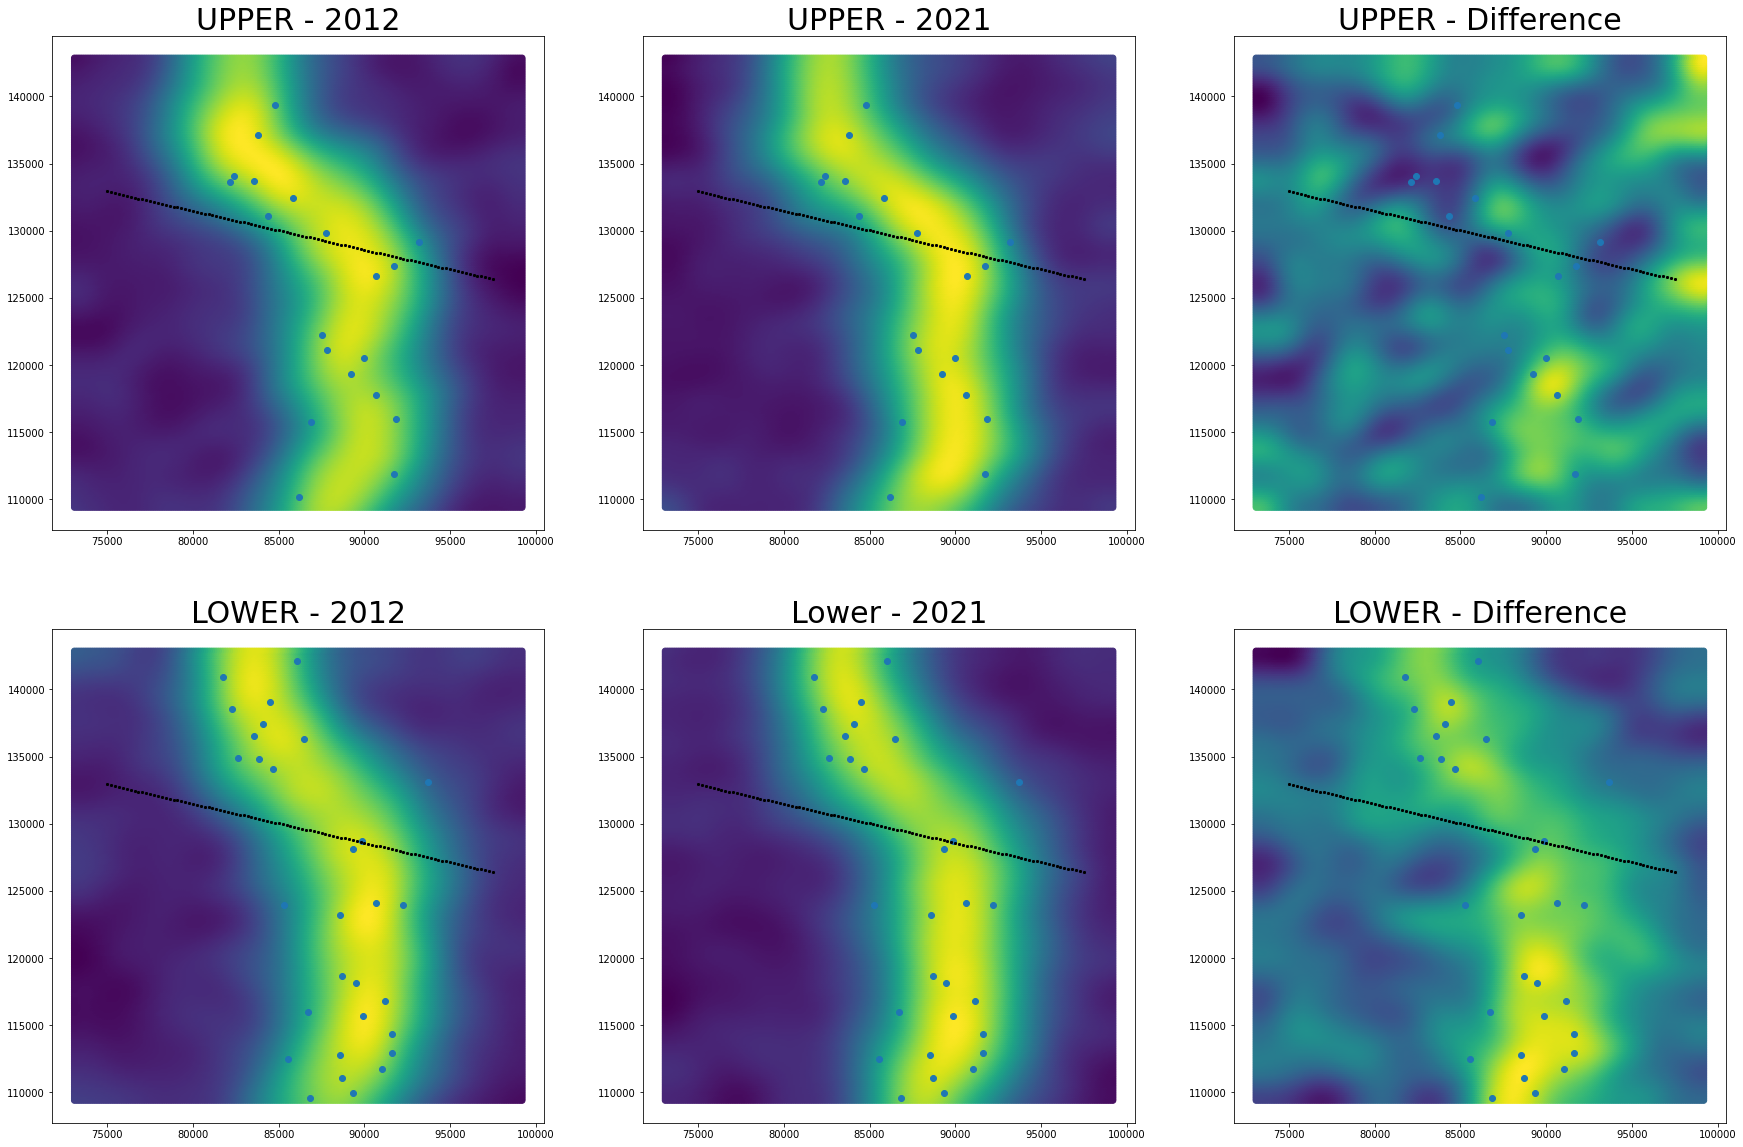

In [57]:
t = np.linspace(75000, 97500, 100)
fault = -.29*t + 154670

fig, ax = plt.subplots(2, 3, figsize=(30,20))

#ax[0][0] = plt.figure(figsize=(10,10))
ax[0][0].scatter(ai['Y(ft)'], ai['X(ft)'], c=ai['AI_upper(2012-01-01)'], )
uppers = well_positional_df[well_positional_df['Completion'] == 'Upper']
ax[0][0].scatter(uppers['Y(ft)'], uppers['X(ft)'], cmap='gray')
ax[0][0].scatter(t, fault, s=5, c='black', marker='x', label='faultline')
ax[0][0].set_title('UPPER - 2012', fontsize=30)

#ax[1][0] = plt.figure(figsize=(10,10))
ax[1][0].scatter(ai['Y(ft)'], ai['X(ft)'], c=ai['AI_lower(2012-01-01)'], )
lowers = well_positional_df[well_positional_df['Completion'] == 'Lower']
ax[1][0].scatter(lowers['Y(ft)'], lowers['X(ft)'], cmap='gray')
ax[1][0].set_title('LOWER - 2012', fontsize=30)
ax[1][0].scatter(t, fault, s=5, c='black', marker='x', label='faultline')

#ax[0][1] = plt.figure(figsize=(10,10))
ax[0][1].scatter(ai['Y(ft)'], ai['X(ft)'], c=ai['AI_upper(2021-12-20)'], )
uppers = well_positional_df[well_positional_df['Completion'] == 'Upper']
ax[0][1].scatter(uppers['Y(ft)'], uppers['X(ft)'], cmap='gray')
ax[0][1].set_title('UPPER - 2021', fontsize=30)
ax[0][1].scatter(t, fault, s=5, c='black', marker='x', label='faultline')

#ax[1][1] = plt.figure(figsize=(10,10))
ax[1][1].scatter(ai['Y(ft)'], ai['X(ft)'], c=ai['AI_lower(2021-12-20)'], )
lowers = well_positional_df[well_positional_df['Completion'] == 'Lower']
ax[1][1].scatter(lowers['Y(ft)'], lowers['X(ft)'], cmap='gray')
ax[1][1].set_title('Lower - 2021', fontsize=30)
ax[1][1].scatter(t, fault, s=5, c='black', marker='x', label='faultline')

#ax[0][2] = plt.figure(figsize=(10,10))
ax[1][2].scatter(ai['Y(ft)'], ai['X(ft)'], c= -ai['AI_lower(2012-01-01)'] + ai['AI_lower(2021-12-20)'], )
lowers = well_positional_df[well_positional_df['Completion'] == 'Lower']
ax[1][2].scatter(lowers['Y(ft)'], lowers['X(ft)'], cmap='gray')
ax[1][2].set_title('LOWER - Difference', fontsize=30)
ax[1][2].scatter(t, fault, s=5, c='black', marker='x', label='faultline')

#ax[1][2] = plt.figure(figsize=(10,10))
ax[0][2].scatter(ai['Y(ft)'], ai['X(ft)'], c=-ai['AI_upper(2012-01-01)'] + ai['AI_upper(2021-12-20)'], )
uppers = well_positional_df[well_positional_df['Completion'] == 'Upper']
ax[0][2].scatter(uppers['Y(ft)'], uppers['X(ft)'], cmap='gray')
ax[0][2].set_title('UPPER - Difference', fontsize=30)
ax[0][2].scatter(t, fault, s=5, c='black', marker='x', label='faultline')
# validate using existing wells
plt.show()

### Analyzing Time Series Data and Forecasting 2-year Production
First, we pull in the production history and do a quick time series plot of each well's production over time.

In [15]:
prod_df = pd.read_csv(base_path / "Production_History_Field.csv", index_col="Date")

px.line(prod_df, x=prod_df.index, y=prod_df.columns)

Strip the capped moments of each time series so we can analyze their individual curve characteristics instead of thier position in the overall flow of time and concatenate them into a DataFrame.

In [41]:
well_time_series = [prod_df[prod_df[column] != 0][column].reset_index(drop=True) for column in prod_df.columns]
well_time_series_df = pd.concat(well_time_series, axis=1)

Segment the data we have into data with at least 24 months and data with less than 24 months. Additionally, we drop the permanantly capped well.


In [58]:
# We want the indices to be strings so they transpose as column names with strings
well_time_series_df.index = [str(x) for x in well_time_series_df.index]
two_year_well_df = well_time_series_df.loc[:, well_time_series_df.isnull().sum() < (107-24)].T
# 
two_year_missing_df = well_time_series_df.loc[:, well_time_series_df.isnull().sum() > (107-24)].T
# Remove because it was never uncapped
two_year_missing_df = two_year_missing_df.drop("WOPR:WP11(bbl/day)")

Regressing on the initial production and initial derivate in production to find the 2 year (24 month) cumulative production.

In [45]:
# Engineer features
two_year_well_df["Derivative (bbl/day/month)"] = two_year_well_df["1"] - two_year_well_df["0"]
two_year_well_df["2-year Prod (bbl)"] = two_year_well_df.loc[:, "0":"24"].sum(axis=1)
# Rename for clarity of graphics
two_year_well_df = two_year_well_df.rename(columns={"0": "Initial Rate (bbl/day)"})
plotting_data = two_year_well_df

# plot data in 3D scatter
fig = px.scatter_3d(plotting_data, x="Initial Rate (bbl/day)", y="Derivative (bbl/day/month)", z="2-year Prod (bbl)", hover_name=plotting_data.index, title="Initial Rate and Derivative vs. 2-year Production", width=800, height=800)
fig.update_traces(marker=dict(color="#BF5700"))
fig.show()

It's planar! Let's make a model

In [46]:
# Create Linear Model to predict
two_year_X = two_year_well_df[["Initial Rate (bbl/day)", "Derivative (bbl/day/month)"]]
two_year_y = two_year_well_df["2-year Prod (bbl)"]
train_X, test_X, train_y, test_y = train_test_split(two_year_X, two_year_y, test_size=.2, random_state=42)
two_year_model = LinearRegression()
two_year_model.fit(train_X, train_y)
two_year_preds = two_year_model.predict(test_X)
r2_scored = r2_score(two_year_preds, test_y)
r2_scored

0.9975131313830568

Model looks alright! Let's make our predictions so that we can have all wells with a 2-year cumulative estimation

In [49]:
two_year_missing_df["Derivative (bbl/day/month)"] = two_year_missing_df["1"] - two_year_missing_df["0"]
two_year_missing_df = two_year_missing_df.rename(columns={"0": "Initial Rate (bbl/day)"})
two_year_missing_df["2-year Prod (bbl)"] = two_year_model.predict(two_year_missing_df[["Initial Rate (bbl/day)", "Derivative (bbl/day/month)"]])

We combine all of our predictions and actual two-year productions into a single series!

In [51]:
full_two_year_prod = pd.concat([two_year_missing_df["2-year Prod (bbl)"], two_year_y], axis=0)
full_two_year_prod

WOPR:WP15(bbl/day)    72527.341096
WOPR:WP17(bbl/day)    32378.675544
WOPR:WP20(bbl/day)      745.327005
WOPR:WP25(bbl/day)    30805.819758
WOPR:WP31(bbl/day)    11198.633757
WOPR:WP32(bbl/day)    37265.296935
WOPR:WP35(bbl/day)     -121.773416
WOPR:WP39(bbl/day)      132.090508
WOPR:WP40(bbl/day)      972.824703
WOPR:WP46(bbl/day)    30771.781314
WOPR:WP7(bbl/day)       -29.227442
WOPR:WP0(bbl/day)       220.623568
WOPR:WP1(bbl/day)       967.220104
WOPR:WP10(bbl/day)     1165.743198
WOPR:WP12(bbl/day)       17.758218
WOPR:WP13(bbl/day)      586.702696
WOPR:WP14(bbl/day)    10456.887672
WOPR:WP16(bbl/day)    37745.757428
WOPR:WP18(bbl/day)     7935.172962
WOPR:WP19(bbl/day)      178.579386
WOPR:WP2(bbl/day)       134.496098
WOPR:WP21(bbl/day)       39.829815
WOPR:WP22(bbl/day)      328.990467
WOPR:WP23(bbl/day)      159.580914
WOPR:WP24(bbl/day)     2604.450074
WOPR:WP26(bbl/day)    12886.843013
WOPR:WP27(bbl/day)      228.263249
WOPR:WP28(bbl/day)     3505.962752
WOPR:WP29(bbl/day)  

## Imputation and Encoding

#### Binary Imputation

We impute the zone as upper or lower just based on the position in terms of X, Y, and MD(ft) using K-Nearest Neighbors

In [6]:
# Encode Zone and Completion Zone
master_df = master_df.replace({'Upper': 1,'Lower': 0})

# Impute missing zone values

knn_model = KNeighborsClassifier(n_neighbors=1)
missing_zone = master_df["Zone"].isnull()

knn_model.fit(master_df.loc[~missing_zone,['X','Y','MD(ft)']], master_df.loc[~missing_zone, 'Zone'])


test = knn_model.predict(master_df.loc[missing_zone,['X','Y','MD(ft)']])
master_df.loc[missing_zone, 'Zone'] = knn_model.predict(master_df.loc[missing_zone,['X','Y','MD(ft)']])

#### Continuous Imputation

First, we scale each of our distance-based metrics by the same scaler to ensure that the relationships between each of them is preserved.

In [7]:
distance_scaler = StandardScaler()
master_df["scaled_X"] = distance_scaler.fit_transform(master_df["X"].to_numpy().reshape(-1, 1))
master_df["scaled_Y"] = distance_scaler.transform(master_df["Y"].to_numpy().reshape(-1, 1))
master_df["scaled_MD"] = distance_scaler.transform(master_df["MD(ft)"].to_numpy().reshape(-1, 1))

Below is a function to run imputation on a feature.

In [8]:
def knn_imp(well_log: pd.DataFrame,
            replace_var: str = 'DT(us/ft)', 
            predictors: Tuple[str] = ('scaled_X','scaled_Y','scaled_MD')) -> pd.DataFrame:
    """
    Imputes values using scaling, KNN model, and Grid CV.
    """

    # CV testing params
    parameters = {'weights': ('uniform', 'distance'), 
              'n_neighbors':[4, 6, 8, 10, 12]}
    
    # Initialize model
    knn = KNeighborsRegressor()
    gcv = GridSearchCV(knn, parameters, cv=KFold(random_state=2, shuffle=True), error_score="raise")
    
    # Grab missing location
    missing_Var = well_log[replace_var].isnull()
    
    data = well_log.loc[~missing_Var, list(predictors) + [replace_var,]]
    
    X = data[list(predictors)]
    y = data[replace_var]
    scaler = StandardScaler()
    y_scaled = scaler.fit_transform(y.values.reshape(-1,1))

    gcv.fit(X, y_scaled)
    
    print(f'\nReplaced Variable: {replace_var}\n{gcv.best_estimator_}\n')

    #test = gcv.predict(well_log.loc[missing_Var,predictors])
    well_log.loc[missing_Var, replace_var] = scaler.inverse_transform(gcv.predict(well_log.loc[missing_Var,predictors]))

    return well_log

Next, we impute and create histograms.


Replaced Variable: DT(us/ft)
KNeighborsRegressor(n_neighbors=4, weights='distance')


Replaced Variable: RHOB(g/cm3)
KNeighborsRegressor(n_neighbors=4, weights='distance')


Replaced Variable: ROP
KNeighborsRegressor(n_neighbors=12, weights='distance')


Replaced Variable: RD(OHMM)
KNeighborsRegressor(n_neighbors=12, weights='distance')


Replaced Variable: RS(OHMM)
KNeighborsRegressor(n_neighbors=12)


Replaced Variable: PEF(B/E)
KNeighborsRegressor(n_neighbors=12, weights='distance')


Replaced Variable: DENC(g/cm3)
KNeighborsRegressor(n_neighbors=12)


Replaced Variable: DTS(us/ft)
KNeighborsRegressor(n_neighbors=12, weights='distance')



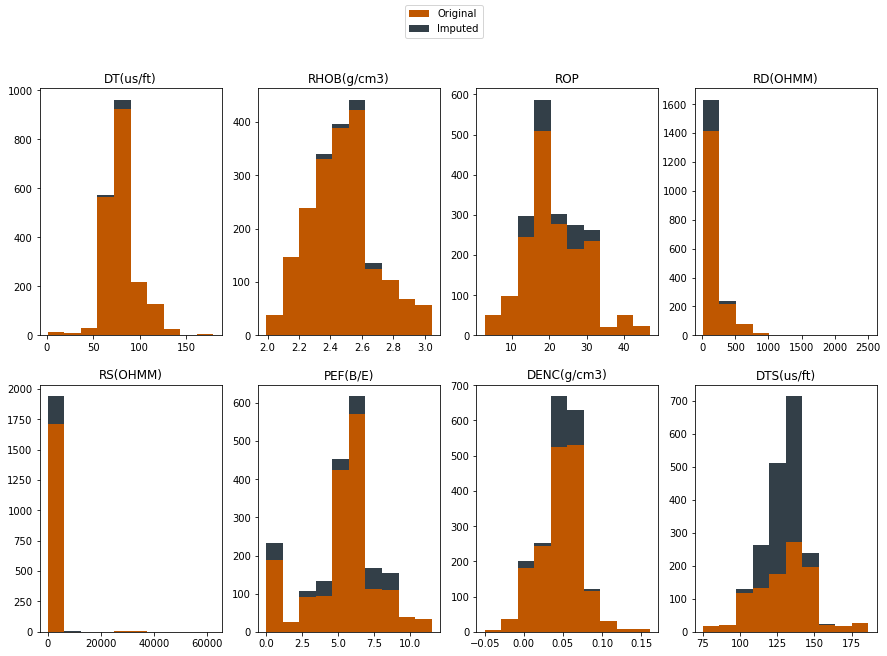

In [9]:
cont_impute_features = ["DT(us/ft)", "RHOB(g/cm3)", "ROP", "RD(OHMM)", "RS(OHMM)", "PEF(B/E)", "DENC(g/cm3)", "DTS(us/ft)"  ]

fig, ax = plt.subplots(2, 4, figsize=(15, 10))

for idx, feat in enumerate(cont_impute_features):
    ax[idx // 4][idx % 4].hist(master_df[feat], color="#BF5700", label="Original", zorder=10)
    master_df= knn_imp(master_df, feat)
    ax[idx // 4][idx % 4].hist(master_df[feat], color="#333F48", label="Imputed", zorder=0)
    ax[idx // 4][idx % 4].title.set_text(feat)

handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
fig.show()

The histograms offer a quick look at the distribution of data for each variable. Original values are burnt orange, while imputed values are dark gray. 

The porosity data was very sparse, so we had to impute it in a different way. 

In [12]:
missing_porosity = master_df['PORO(v/v)'].isnull()
porosity_df = master_df.drop(['Permeability(mD)', 'well_id'], axis =1)

scalers = [MaxAbsScaler(), MinMaxScaler(), StandardScaler(), RobustScaler()]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('poly', PolynomialFeatures()),
    ('reg', LinearRegression())
])

params = {
    'scaler': scalers,
    'poly__degree': [1, 2, 3],
    'pca__n_components': [1, 2, 3, 4, 5, 6]
}


gcv = GridSearchCV(pipe, params, cv=KFold(random_state=5, shuffle=True),error_score='raise')
gcv.fit(porosity_df[~missing_porosity].drop(['PORO(v/v)'], axis=1), 
        porosity_df.loc[~missing_porosity, 'PORO(v/v)'])
gcv.best_params_


porosity_df.loc[missing_porosity, 'PORO(v/v)'] = gcv.predict(porosity_df[missing_porosity].drop('PORO(v/v)', axis=1))



We attempted to impute permeability, but the values appeared innacurate. We discarded permability in the remainder of our evaluation.

In [13]:
phi = porosity_df['PORO(v/v)']
perm_est = phi ** 3 / (1 - phi) ** 2 *1800

porosity_df['perm_est'] = perm_est 

Add back well_id and summarize with the mean for each feature in each well.

In [14]:
master_df = porosity_df.merge(master_df['well_id'], left_index=True, right_index=True)

summarized_df = master_df.groupby('well_id').mean()


## Modeling

Now we start working on the final model

In [60]:
#prepare our data
#we work with two frames: wells, and data

###build wells
wells = pd.read_csv('/work/Carpe-Datum-2022/Well_Head_and_Completion.csv')
wm = pd.read_csv('/work/Carpe-Datum-2022/Well_Log/WELL_MASTER_AI.csv')
wells = wells.merge(wm, how='left', left_on='WELL', right_on='well_id',).drop_duplicates('WELL')
new = pd.read_csv('/work/Carpe-Datum-2022/EDA_notebooks/new_df2.csv')
wells = wells.merge(new, how='left', left_on='WELL', right_on='Unnamed: 0', suffixes=(None,'_y'))
wells['line'] = -.29*wells['Y(ft)']+154670
time = pd.read_csv('/work/Carpe-Datum-2022/Production_History_Field.csv')
z = pd.DataFrame()
z['Start Date'] = time['Date'].iloc[time.drop('Date',axis=1).ne(0).idxmax()]
z['Well'] = time.drop('Date', axis=1).columns
z['Well'] = z['Well'].str.replace('WOPR:','').str.replace('\(bbl/day\)','')
z['Age'] = (pd.to_datetime('today') - pd.to_datetime(z['Start Date'])).dt.days
wells = wells.merge(z, how='left', left_on='WELL', right_on='Well')


###build data
data = pd.read_csv('/work/Carpe-Datum-2022/Well_Log/WELL_MASTER_AVG.csv')
data2 = pd.read_csv('/work/Carpe-Datum-2022/EDA_notebooks/two_year_forecast.csv')
data2['Well'] = data2['Unnamed: 0'].str.replace('WOPR:','').str.replace('\(bbl/day\)','')
data = data.merge(data2[['sum','Well']], left_on='well_id', right_on='Well')
data['diff_lower'] = data['AI_lower(2021-12-20)'] - data['AI_lower(2012-01-01)']
data['diff_upper'] = data['AI_upper(2021-12-20)'] - data['AI_upper(2012-01-01)']
data['log_sum'] = np.log(data['sum'])

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

The default value of regex will change from True to False in a future version.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning:

The default value of regex will change from True to False in a future version.



In [61]:
from sklearn.metrics import mean_squared_error
import scipy.interpolate as interpolate
from sklearn.neighbors import NearestNeighbors
import time

###HERE IS THE BULK OF OUR WORK IN VALIDATION
### For each well, we remove the well data, then predict it

### we also generate our predictions in this block


def validate(model, features):
    tot_mae = 0
    ai = pd.read_csv('/work/Carpe-Datum-2022/AI.csv')
    ai = ai.rename({'X(ft)':'X','Y(ft)':'Y'}, axis=1)
    r = 2000

    ###Iterate through each well
    for i, well in enumerate(data['Well']):

        #create vars with current well and missing current well
        d = data[data['Well'] != well] #the data without the current well
        dd = data[data['Well'] == well] #the current well to predict
        
        #if we're using neighbor data as a feature, build a knn model
        if 'Neighbor' in features:
            nn = NearestNeighbors().fit(d[['X','Y']]).radius_neighbors(d[['X','Y']], radius=r)[1]
            d['Neighbor'] = [len(u) for u in nn]
        model.fit(d[features], d['log_sum'],) #predict well prod based on features 
        to_predict = pd.Series()
        well_n = NearestNeighbors()

        #go through each feature, estimate it for the well
        #on the first well estimate features for each point in the acoustic emission frame
        for feature in features:
            knn_tp = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=10, weights = 'distance', p=2))
            knn_tp.fit(d[['X','Y','AI_lower(2012-01-01)']], d[[feature]])

            #if the feature is in a list that was pre calculated for each well
            if feature in ['X', 'Y', 'AI_lower(2012-01-01)', 'AI_upper(2012-01-01)', 'AI_lower(2021-12-20)', 'AI_upper(2021-12-20)']:
                to_predict[feature] = dd.iloc[0][feature]
                continue
            #if its the difference in acoustic impedence from the lower set
            if feature == 'diff_lower':
                ai['diff_lower'] = ai['AI_lower(2021-12-20)'] - ai['AI_lower(2012-01-01)']
                to_predict[feature] = knn_tp.predict(dd[['X','Y','AI_lower(2012-01-01)']]).reshape(-1,1)
                continue
            #if its the difference from the upper set
            if feature == 'diff_upper':
                ai['diff_upper'] = ai['AI_upper(2021-12-20)'] - ai['AI_upper(2012-01-01)']
                to_predict[feature] = knn_tp.predict(dd[['X','Y','AI_lower(2012-01-01)']]).reshape(-1,1)
                continue
            #if the feature is the zone (we make all predictions in zone 0)
            if feature == 'Neighbor':
                #d[feature] = NearestNeighbors().fit(d[['X','Y']]).radius_neighbors(d[['X','Y']])
                nn = NearestNeighbors().fit(d[['X','Y']]).radius_neighbors(ai[['X','Y']], radius=r)[1]
                ai['Neighbor'] = [len(u) for u in nn]
                nn = NearestNeighbors().fit(d[['X','Y']]).radius_neighbors(to_predict[['X','Y']].to_numpy().reshape(1,-1), radius=r)[1]
                print(nn)
                to_predict['Neighbor'] = [len(u) for u in nn]
            if feature == 'Zone':
                ai['Zone'] = 0
                to_predict['Zone'] = 0
                continue
            
            #t2 = time.time()
            #print(t2-t1)

            #while doing first well, estimate features for each acoustic impedence location
            #we do this because estimating accross the map only needs to be done once
            if i == 0:
                knn_ai = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=10, weights = 'distance', p=2))
                knn_ai.fit(d[['X','Y','AI_lower(2012-01-01)']], d[[feature]])
                #ai[feature] = interpolate.griddata(data[['X','Y']], data[feature], ai[['X','Y']],method='linear')
                #missing = np.isnan(ai[feature])
                results = knn_ai.predict(ai[['X','Y','AI_lower(2012-01-01)']])
                #print(results.shape)
                #print(ai.shape)
                ai[feature] = results.reshape(-1,1)
            # print(i)

            #to_predict[feature] = interpolate.griddata(d[['X','Y']], d[feature], data[data['Well'] == well].iloc[0][['X','Y']],method='linear')[0]
            to_predict[feature] = knn_tp.predict(dd[['X','Y','AI_lower(2012-01-01)']]).reshape(-1,1)

            # if np.isnan(to_predict[feature]):
            #     results = knn_tp.predict(dd[['X','Y']])[0]
            #     to_predict[feature] = results[0]
            #print(to_predict)
            
            #print(feature)
        pred = np.exp(model.predict(to_predict.to_numpy().reshape(1,-1)))
        #pred = np.exp(model.predict(dd.iloc[0][features].to_numpy().reshape(1,-1)))
        #print(pred)
        tot_mae += 100/48*np.abs((pred[0] - data[data['Well'] == well].iloc[0]['sum']) / data[data['Well'] == well].iloc[0]['sum'])

    t = np.linspace(75000, 97500, 100)
    fault = -.29*t + 154670

    plt.figure(figsize=(15,10))
    ai['pred'] = np.exp(model.predict(ai[features]))
    #plt.scatter(sum_interp['Y'], sum_interp['X'], c=sum_interp['PORO(v/v)'], )
    plt.scatter(ai['Y'], ai['X'], c=np.log(ai['pred']), label='Log Predicted Production')
    #mynorm = plt.Normalize(vmin=0, vmax=100000)
    #plt.colorbar()
    uppers = wells
    plt.scatter(uppers['Y(ft)'], uppers['X(ft)'], s=50, c='black', cmap='gray')

    plt.title('Recommended Well Location', fontsize=30)
    plt.xlabel("Y(ft)", fontsize=20)
    plt.ylabel("X(ft)", fontsize=20)
    plt.scatter(t, fault, s=5, c='black', marker='x', label='faultline')
    plt.scatter(y=[112546.64], x=[89091.36], c='red', marker='x', s=200, label='Well')
    plt.scatter(y=[115039.44], x=[89878.56], c='red', marker='x', s=200)
    plt.scatter(y=[113639.44], x=[89700.56], c='red', marker='x', s=200)
    plt.legend(fontsize=15)
    plt.show()

    return tot_mae / data['Well'].shape[0], ai

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning:

The default dtype for empty Seri

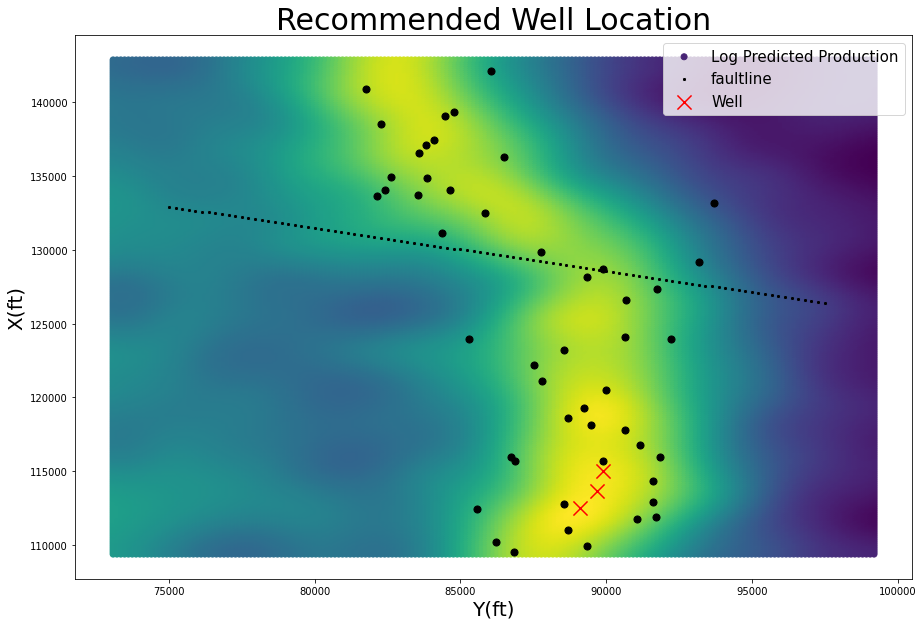

In [64]:
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
np.random.seed(99998)

#make_pipeline(PolynomialFeatures(), LinearRegression())
z=validate(LinearRegression(), ['AI_lower(2012-01-01)','AI_upper(2012-01-01)','AI_upper(2021-12-20)','AI_lower(2021-12-20)','X','Y',])
#print(z)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning:

The default dtype for 

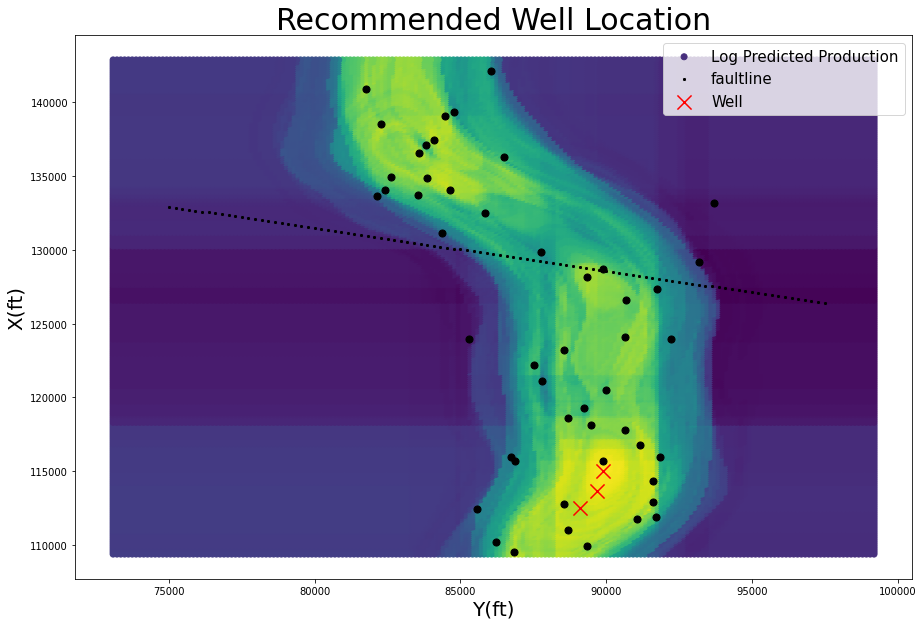

In [65]:
#first do the random forest estimate 
z, ai=validate(RandomForestRegressor(), ['AI_lower(2012-01-01)','AI_upper(2012-01-01)','AI_upper(2021-12-20)','AI_lower(2021-12-20)','X','Y'])
#print(z)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b71fecc-b405-4b93-bce3-c5ed6c21c449' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>